[*********************100%***********************]  1 of 1 completed


Price,date,close
Ticker,,MSFT
0,2015-01-02,39.933064
1,2015-01-05,39.565834
2,2015-01-06,38.985126
3,2015-01-07,39.480434
4,2015-01-08,40.641865


(2715, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   (date, )       2715 non-null   datetime64[ns]
 1   (close, MSFT)  2715 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.6 KB


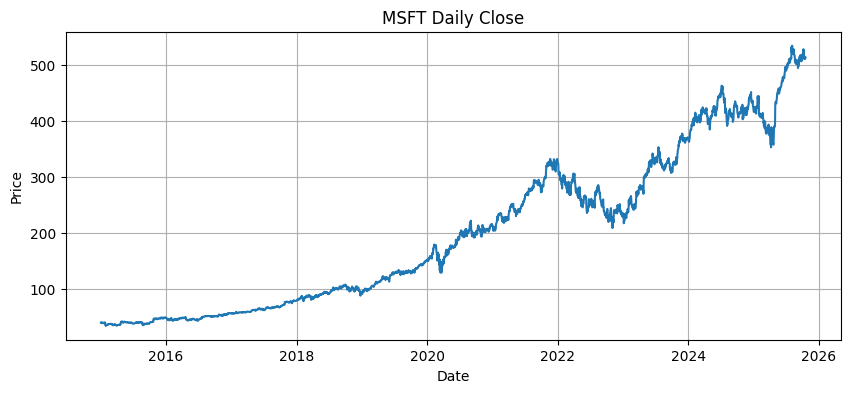

Saved clean dataset to: /content/stock_prices.csv  (columns: date, close)


In [5]:
# install & imports
!pip -q install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# choose the ticker
TICKER = "MSFT"

# date range (from 2015 to today)
start = "2015-01-01"
end = pd.Timestamp.today().normalize()

# download daily prices
df = yf.download(TICKER, start=start, end=end, interval="1d", auto_adjust=True)
df = df.rename_axis("date").reset_index()

# keep only what we need for ARIMA (date + Close)
df = df[["date", "Close"]].dropna().rename(columns={"Close": "close"})

# quick sanity checks
display(df.head())
print(df.shape)
df.info()

# simple line plot of closing prices
plt.figure(figsize=(10,4))
plt.plot(df["date"], df["close"])
plt.title(f"{TICKER} Daily Close")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True)
plt.show()

# save the dataset
csv_path = "/content/stock_prices.csv"
df.to_csv(csv_path, index=False)
print(f"Saved clean dataset to: {csv_path}  (columns: date, close)")

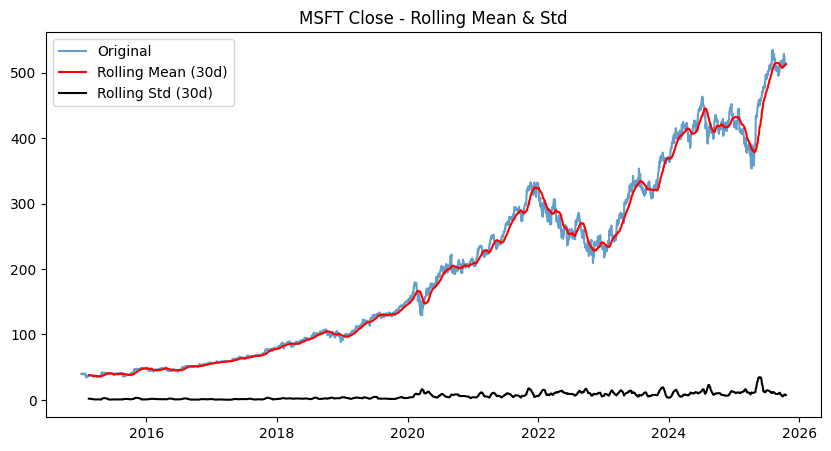

Chosen differencing order d = 1 (ADF p-value on differenced series: 0.0000)
Train size: 2443, Test size: 272


In [7]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Make sure 'date' is the index and sorted
df = df.set_index("date").sort_index()

# Rolling mean/std just to visualize stability
rolling_mean = df["close"].rolling(30).mean()
rolling_std = df["close"].rolling(30).std()

plt.figure(figsize=(10,5))
plt.plot(df["close"], label="Original", alpha=0.7)
plt.plot(rolling_mean, label="Rolling Mean (30d)", color="red")
plt.plot(rolling_std, label="Rolling Std (30d)", color="black")
plt.title("MSFT Close - Rolling Mean & Std")
plt.legend(); plt.show()

# ADF test helper
def adf_pvalue(series):
    return adfuller(series.dropna())[1]

# Choose differencing order d (0→1→2) until stationary (p<=0.05) or d hits 2
d = 0
series = df["close"].copy()
while adf_pvalue(series) > 0.05 and d < 2:
    series = series.diff().dropna()
    d += 1

print(f"Chosen differencing order d = {d} (ADF p-value on differenced series: {adf_pvalue(series):.4f})")

# ---- Time-based train/test split (e.g., last 10% as test)
train_size = int(len(df) * 0.9)
train = df["close"].iloc[:train_size]
test  = df["close"].iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Best ARIMA order by AIC: (4, 1, 5)   (AIC=12867.68)
RMSE: 50.22
MAPE: 8.80%


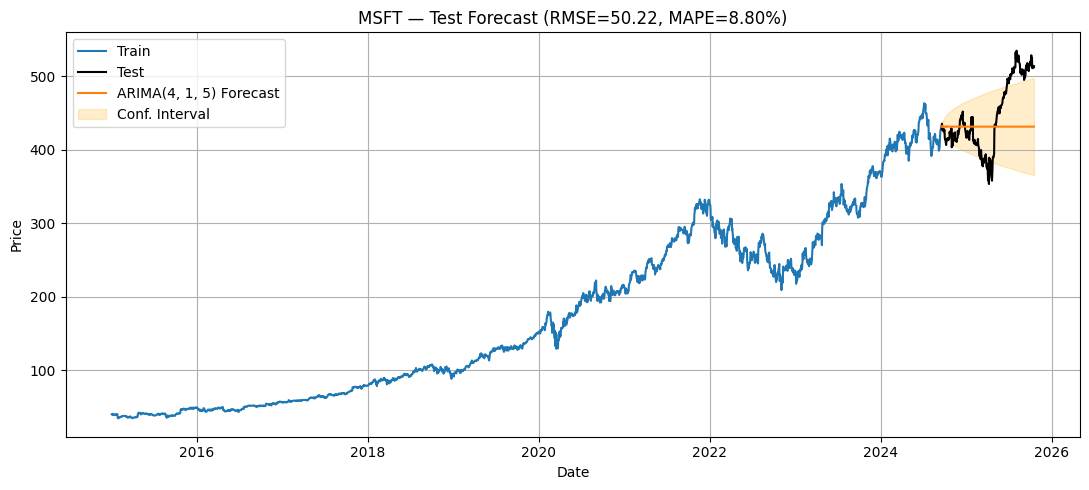

Saved: /content/arima_test_predictions.csv and /content/arima_test_forecast.png


In [12]:

import warnings, itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")



if "d" not in globals(): d = 1
if "TICKER" not in globals(): TICKER = "TICKER"

# Ensure y_train / y_test are 1-D Series
def to_series(x):
    if isinstance(x, pd.DataFrame):
        # if it's a single-column DataFrame, take the first column
        if x.shape[1] == 1:
            return x.iloc[:, 0]
        else:
            raise ValueError("Expected a single-column DataFrame for the series.")
    return x

y_train = to_series(train).astype(float)
y_test  = to_series(test).astype(float)

# small AIC grid search for (p,q) at fixed d
p_vals = range(0, 6)   # 0..5
q_vals = range(0, 6)

best = {"aic": np.inf, "order": None, "model": None}
for p, q in itertools.product(p_vals, q_vals):
    if p == 0 and q == 0:
        continue
    try:
        model = SARIMAX(
            y_train,
            order=(p, d, q),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        res = model.fit(disp=False)
        if res.aic < best["aic"]:
            best = {"aic": res.aic, "order": (p, d, q), "model": res}
    except Exception:
        pass  # skip combos that fail

if best["model"] is None:
    raise RuntimeError("Grid search failed to fit any ARIMA model. Try smaller ranges.")

print(f"Best ARIMA order by AIC: {best['order']}   (AIC={best['aic']:.2f})")
res = best["model"]

# forecast the test horizon
n_test = len(y_test)
pred = res.get_forecast(steps=n_test)

# Force alignment to test index (avoid NaNs & shape issues)
pred_mean = pd.Series(np.asarray(pred.predicted_mean).reshape(-1), index=y_test.index)

# Confidence interval → robust extraction + align to test index
pred_ci_raw = pred.conf_int(alpha=0.2)  # 80% CI
cols = list(pred_ci_raw.columns)
lower_idx = 0 if len(cols) < 2 else [i for i,c in enumerate(cols) if "lower" in c.lower()][0]
upper_idx = 1 if len(cols) < 2 else [i for i,c in enumerate(cols) if "upper" in c.lower()][0]
ci_lower = pd.Series(np.asarray(pred_ci_raw.iloc[:, lower_idx]).reshape(-1), index=y_test.index)
ci_upper = pd.Series(np.asarray(pred_ci_raw.iloc[:, upper_idx]).reshape(-1), index=y_test.index)

# evaluation
y_actual = np.asarray(y_test).reshape(-1).astype(float)
y_predict  = np.asarray(pred_mean).reshape(-1).astype(float)

mse  = mean_squared_error(y_actual, y_predict)
rmse = float(np.sqrt(mse))

den  = np.where(y_actual == 0.0, 1e-8, y_actual)
mape = float((np.abs((y_actual - y_predict) / den).mean()) * 100.0)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# plot train / test / forecast + interval
plt.figure(figsize=(11,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index,  y_test,  label="Test", color="black")
plt.plot(y_test.index,  y_predict,   label=f"ARIMA{best['order']} Forecast", color="tab:orange")
plt.fill_between(y_test.index, ci_lower.values, ci_upper.values,
                 color="orange", alpha=0.2, label="Conf. Interval")
plt.title(f"{TICKER} — Test Forecast (RMSE={rmse:.2f}, MAPE={mape:.2f}%)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("/content/arima_test_forecast.png", dpi=150)
plt.show()

# save predictions to CSV
date_col = np.asarray(y_test.index)
pred_df = pd.DataFrame({
    "date": date_col,
    "actual": y_actual,
    "predicted": y_predict
})
pred_df.to_csv("/content/arima_test_predictions.csv", index=False)
print("Saved: /content/arima_test_predictions.csv and /content/arima_test_forecast.png")

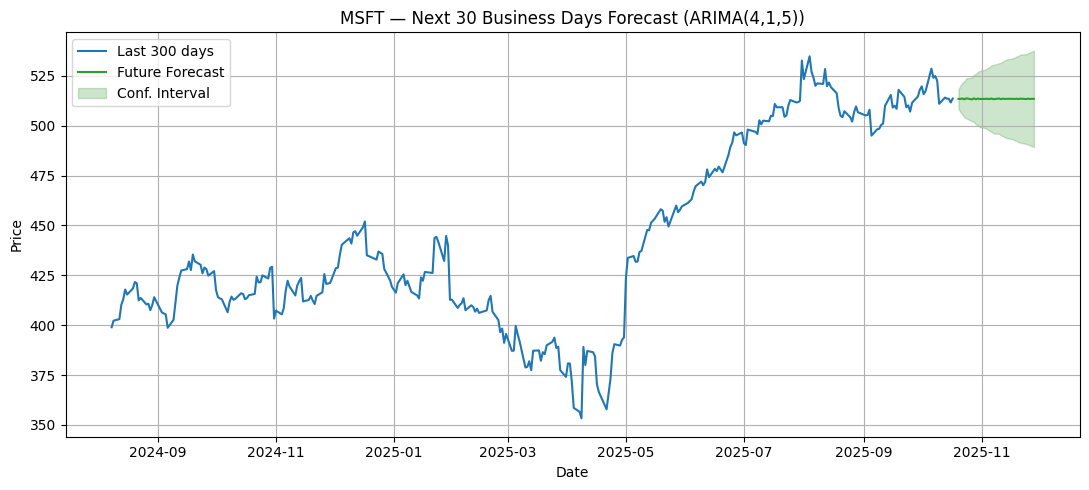

Saved: /content/arima_future_forecast.csv and /content/arima_future_forecast.png


In [13]:
# Future forecast
# Refit on full series with best order
full_model = SARIMAX(df["close"], order=(4,1,5),
                     enforce_stationarity=False, enforce_invertibility=False)
full_res = full_model.fit(disp=False)

steps_ahead = 30
future = full_res.get_forecast(steps=steps_ahead)

# Build a business-day index for the future horizon
last_date = df.index[-1]
future_index = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=steps_ahead)

future_mean = pd.Series(np.asarray(future.predicted_mean).reshape(-1), index=future_index)
ci_raw = future.conf_int(alpha=0.2)
lower_col = [c for c in ci_raw.columns if "lower" in c.lower()][0]
upper_col = [c for c in ci_raw.columns if "upper" in c.lower()][0]
future_lower = pd.Series(np.asarray(ci_raw[lower_col]).reshape(-1), index=future_index)
future_upper = pd.Series(np.asarray(ci_raw[upper_col]).reshape(-1), index=future_index)

# Plot last ~300 days + future
plt.figure(figsize=(11,5))
plt.plot(df.index[-300:], df["close"].iloc[-300:], label="Last 300 days")
plt.plot(future_index, future_mean, label="Future Forecast", color="tab:green")
plt.fill_between(future_index, future_lower.values, future_upper.values,
                 color="green", alpha=0.2, label="Conf. Interval")
plt.title(f"{TICKER} — Next {steps_ahead} Business Days Forecast (ARIMA(4,1,5))")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("/content/arima_future_forecast.png", dpi=150)
plt.show()

# Save CSV
future_df = pd.DataFrame({
    "date": future_index,
    "forecast": future_mean.values,
    "lower": future_lower.values,
    "upper": future_upper.values
})
future_df.to_csv("/content/arima_future_forecast.csv", index=False)
print("Saved: /content/arima_future_forecast.csv and /content/arima_future_forecast.png")